# Create Tritium-$^3\!$He initial fields for CESM1.2.2 so that the diffusive gas exchange balances gas flux due to bubbles
Created by Ivan Lima on Tue, 16 Aug 2016 09:25:54 -0400

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os, netCDF4, gsw, datetime
from matplotlib import colors, ticker
from cartopy.util import add_cyclic_point
from scipy.interpolate import griddata
from scipy.stats import linregress
from tr3he import *
from mpl_utils import *
from ccsm_utils import read_region_mask
%matplotlib inline
proj = ccrs.Robinson(central_longitude=180+30)

## Read input data

### Model grid & initial temperature & salinity

In [2]:
# model grid info
infile = '/home/ivan/Python/data/gx1v6.nc'
fpin = netCDF4.Dataset(infile,'r')
nz   = len(fpin.dimensions['z_t'])
nlat = len(fpin.dimensions['nlat'])
nlon = len(fpin.dimensions['nlon'])
zt   = fpin.variables['z_t'][:] / 100 # cm -> m
tlat = fpin.variables['TLAT'][:]
tlon = fpin.variables['TLONG'][:]
area = fpin.variables['TAREA'][:] * 1.e-4 # cm^2 -> cm^2
fpin.close()
# initial T & S
datadir = '/bali/data/ilima/cesm/cesm1_input/ocn/pop/gx1v6/ic'
infile  = os.path.join(datadir,'ts_PHC2_jan_ic_gx1v6_20090205.ieeer8')
data    = np.fromfile(infile,dtype='>f8').reshape(2,nz,nlat,nlon)
data    = ma.masked_less_equal(data,-99)
temp, salt = data[0,...], data[1,...]
sst, sss = temp[0,...], salt[0,...]
rmask, nreg, rlname, rsname = read_region_mask('gx1v6') # model region mask

###  NCEP/CORE wind velocity (u10) 

In the new climatological mean, the wind speed was first cubed (squared) and then averaged.

In [3]:
infile   = '/home/ivan/Data/Postproc/Tritium-3H/u10_1948-2007_mean.nc'
fpin     = netCDF4.Dataset(infile,'r')
ncep_lat = fpin.variables['lat'][:]
ncep_lon = fpin.variables['lon'][:]
ncep_u10 = fpin.variables['u10'][:]
ncep_u10_square = fpin.variables['u10_square'][:]
ncep_u10_cube   = fpin.variables['u10_cube'][:]   # (u10 - 2.27)^3
fpin.close()

dlon = np.diff(ncep_lon)[0]
ulon = np.arange(ncep_lon[0]-dlon/2,ncep_lon[-1]+dlon,dlon)
ulon = np.where(ulon>180,ulon-360,ulon)
dlat = np.diff(ncep_lat).mean()
ulat = np.arange(ncep_lat[0]-dlat/2,ncep_lat[-1]+dlat,dlat)

#### $u_{10}^2$ and $u_{10}^3$ maps

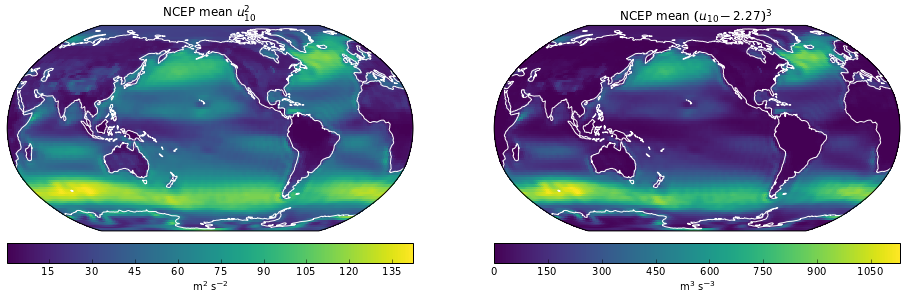

In [4]:
fig, axs = plt.subplots(ncols=2,subplot_kw={'projection':proj},figsize=(16,7))

axs[0].coastlines(color='white')
pm = axs[0].pcolormesh(ulon,ulat,ncep_u10_square,transform=ccrs.PlateCarree())
cb = fig.colorbar(pm,ax=axs[0],orientation='horizontal',pad=0.03)
cb.set_label('m$^2$ s$^{-2}$')
axs[0].set(title='NCEP mean $u_{10}^2$')

axs[1].coastlines(color='white')
pm = axs[1].pcolormesh(ulon,ulat,ncep_u10_cube,transform=ccrs.PlateCarree())
cb = fig.colorbar(pm,ax=axs[1],orientation='horizontal',pad=0.03)
cb.set_label('m$^3$ s$^{-3}$')
axs[1].set(title='NCEP mean $(u_{10} - 2.27)^3$')

#### Interpolate NCEP/CORE u10 to model grid

In [5]:
data  , lon2 = add_cyclic_point(ncep_u10,coord=ncep_lon)        # add cyclic points to data & lon to avoid gaps
square, lon2 = add_cyclic_point(ncep_u10_square,coord=ncep_lon) # add cyclic points to data & lon to avoid gaps
cube  , lon2 = add_cyclic_point(ncep_u10_cube,coord=ncep_lon)   # add cyclic points to data & lon to avoid gaps
lon2, lat2 = np.meshgrid(lon2,ncep_lat)

u10 = griddata((lon2.ravel(),lat2.ravel()),data.ravel(),(tlon,tlat),method='linear')
u10 = ma.masked_where(np.isnan(u10),u10)

u10_square = griddata((lon2.ravel(),lat2.ravel()),square.ravel(),(tlon,tlat),method='linear')
u10_square = ma.masked_where(np.isnan(u10_square),u10_square)

u10_cube = griddata((lon2.ravel(),lat2.ravel()),cube.ravel(),(tlon,tlat),method='linear')
u10_cube = ma.masked_where(np.isnan(u10_cube),u10_cube)

u10 = u10.filled(4.75)               # fill masked area around north pole
u10_square = u10_square.filled(27.5) # fill masked area around north pole
u10_cube = u10_cube.filled(70)       # fill masked area around north pole

#### Maps of temperature, salinity & interpolated u10 fields

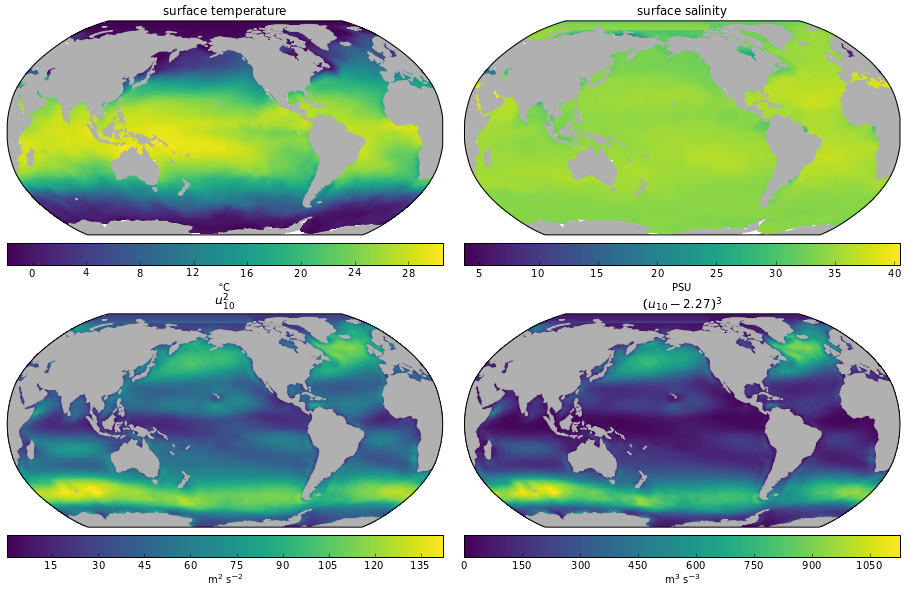

In [6]:
# make coordinates cyclic for plotting
tlonc = np.concatenate((tlon,tlon[:,0,np.newaxis]),axis=-1)
tlatc = np.concatenate((tlat,tlat[:,0,np.newaxis]),axis=-1)
loncp = np.where(np.greater_equal(tlon,tlon[:,0].min()),tlon-360,tlon) # lon for contour plots (monotonic)

fig, axs = plt.subplots(nrows=2,ncols=2, subplot_kw={'projection':proj},figsize=(16,10))
fig.subplots_adjust(wspace=0.05,hspace=0.1)

axs[0,0].add_feature(cfeature.LAND,facecolor='#b0b0b0')
pm = axs[0,0].pcolormesh(tlonc,tlatc,sst,transform=ccrs.PlateCarree())
cb = fig.colorbar(pm,ax=axs[0,0],orientation='horizontal',pad=0.03)
cb.set_label(r'$^{\circ}$C')
axs[0,0].set(title='surface temperature')

axs[0,1].add_feature(cfeature.LAND,facecolor='#b0b0b0')
pm = axs[0,1].pcolormesh(tlonc,tlatc,sss,transform=ccrs.PlateCarree())
cb = fig.colorbar(pm,ax=axs[0,1],orientation='horizontal',pad=0.03)
cb.set_label(r'PSU')
axs[0,1].set(title='surface salinity')

axs[1,0].add_feature(cfeature.LAND,facecolor='#b0b0b0')
pm = axs[1,0].pcolormesh(tlonc,tlatc,u10_square,transform=ccrs.PlateCarree())
cb = fig.colorbar(pm,ax=axs[1,0],orientation='horizontal',pad=0.03)
cb.set_label('m$^2$ s$^{-2}$')
axs[1,0].set(title='$u_{10}^2$')

axs[1,1].add_feature(cfeature.LAND,facecolor='#b0b0b0')
pm = axs[1,1].pcolormesh(tlonc,tlatc,u10_cube,transform=ccrs.PlateCarree())
cb = fig.colorbar(pm,ax=axs[1,1],orientation='horizontal',pad=0.03)
cb.set_label('m$^3$ s$^{-3}$')
axs[1,1].set(title='$(u_{10} - 2.27)^3$')

## Surface $^4\!$He & $^3\!$He fields at saturation given initial temperature & salinity

The $^4$He equilibrium concentration ($C_{He_{eq}}$) in mol m$^{-3}$ is given by the Henry's solubility constant times the partial pressure of $^4$He in the atmosphere:

$$ C_{He_{eq}} = K_h X_{He} P_{atm} $$

$K_h$ = $^4$He solubility (mol m$^{-3}$ Pa$^{-1}$), $X_{He}$ = $^4$He atmospheric mole fraction and $P_{atm}$ = atmospheric pressure (Pa). The $^3$He equilibrium concentration ($C_{eq}$) is computed as the $^4$He equilibrium concentration ($C_{He_{eq}}$) times the $^3\!$He/$^4\!$He isotopic ratio ($I_r$) and the temperature-dependent solubility fractionation factor ($\alpha_S$):

$$ C_{eq} = C_{He_{eq}}\,I_r\,\alpha_S $$

In [7]:
he4_sol = comp_henry_he_sol_0(sst,sss)
alpha_sol = alpha_sol_he(sst)
# he4_sol = comp_henry_he_sol_0(temp,salt)
# alpha_sol = alpha_sol_he(temp)
he4_sat = he4_sol * Xhe * Patm
he3_sat = he4_sat * Ir  * alpha_sol

### $^4\!$He & $^3\!$He saturation maps

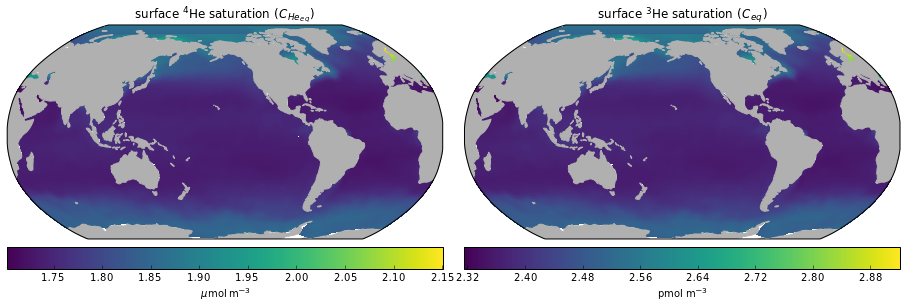

In [8]:
fig, ax = plt.subplots(ncols=2,subplot_kw={'projection':proj},figsize=(16,5))
fig.subplots_adjust(wspace=0.05)

ax[0].add_feature(cfeature.LAND,facecolor='#b0b0b0')
pm0 = ax[0].pcolormesh(tlonc,tlatc,he4_sat*1.e+6,transform=ccrs.PlateCarree()) # mol/m^3 -> umol/m^3
cb0 = fig.colorbar(pm0,ax=ax[0],orientation='horizontal',pad=0.03)
cb0.set_label(r'$\mu$mol m$^{-3}$')
ax[0].set(title=r'surface $^4$He saturation ($C_{He_{eq}}$)')

ax[1].add_feature(cfeature.LAND,facecolor='#b0b0b0')
pm1 = ax[1].pcolormesh(tlonc,tlatc,he3_sat*1.e+12,transform=ccrs.PlateCarree()) # mol/m^3 -> pmol/m^3
cb1 = fig.colorbar(pm1,ax=ax[1],orientation='horizontal',pad=0.03)
cb1.set_label(r'pmol m$^{-3}$')
ax[1].set(title=r'surface $^3$He saturation ($C_{eq}$)')

## $^3\!$He gas fluxes

### Diffusive gas exchange

The $^3\!$He difusive gas exchange (mol m$^{-2}$ s$^{-1}$) is given by:

$$ F_{GE} = k \left(C_{eq} - C_{w}\right) $$

The gas transfer velocity ($k$) is computed as:

$$ k = 6.02\times10^{-7}\;u_{10}^2 \sqrt{\frac{666}{\frac{S_C}{\alpha_D}}} $$

$u_{10}$ = wind speed at 10 m, $S_C$ = Schmidt number, $\alpha_D$ = $^3\!$He/$^4\!$He diffusivity ratio and $C_{w}$ = $^3\!$He concentration in the water.

### Completely trapped bubbles

The $^3\!$He flux due to completely trapped bubbles (mol m$^{-2}$ s$^{-1}$) is given by:

$$ F_C = 9.1 \times 10^{-11} \left(u_{10} - 2.27\right)^3 \frac{P_{a}}{R\,T} $$

$P_{a}$ = partial pressure of $^3$He in the atmosphere, $R$ = ideal gas constant and $T$ = temperature in Kelvin. The partial pressure of $^3$He is computed as:

$$ P_{a} = X_{He} P_{atm} I_r $$

$X_{He}$ = $^4$He atmospheric mole fraction, $P_{atm}$ = atmospheric pressure (Pa) and $I_r$ = $^3$He/$^4$He isotopic ratio.

### Partially trapped bubbles

The $^3\!$He flux due to partially trapped bubbles (mol m$^{-2}$ s$^{-1}$) is computed as:

$$F_P = 2.2 \times 10^{-3} \left(u_{10} - 2.27\right)^3 \beta\,D^{\frac{2}{3}} \frac{P_b - P_w}{R\,T}$$

$\beta$ = Bunsen solubility coefficient for $^3\!$He, $D$ = diffudivity coefficient for $^3\!$He (m$^2$ s$^{-1}$), $P_b$ = $^3\!$He partial pressure in the bubble and $P_w$ = $^3\!$He partial pressure in the water. The Bunsen solubility coefficient for $^3\!$He ($\beta$) is given by:

$$ \beta = \alpha_S\,\beta_{^4\!He} $$

$\beta_{^4\!He}$ = Bunsen solubility for $^4\!$He, $\alpha_S$ = temperature dependent solubility fractionation factor. The diffusivity coefficient for $^3\!$He is given by.

$$ D = \alpha_D\,D_{^4\!He} $$

$D_{^4\!He}$ = diffudivity coefficient for $^4\!$He, $\alpha_D$ = $^3\!$He/$^4\!$He diffusivity ratio. The $^3\!$He partial pressure in the bubble is computed as:

$$ P_b = X_{He} I_r \left(P_{atm} + \rho g z_b\right) $$

$X_{He}$ = $^4\!$He atmospheric mole fraction, $I_r$ = $^3\!$He/$^4\!$He isotopic ratio, $P_{atm}$ = atmospheric pressure (Pa), $\rho$ = density of seawater (kg m$^{-3}$), $g$ = gravitational acceleration (m s$^{-2}$) and $z_b$ = depth of the bubble (m). The bubble depth is a function of $u_{10}$ and computed as:

$$ z_b = 0.15 u_{10} - 0.55 $$

The $^3\!$He partial pressure in the water is computed as:
$$ P_w = \frac{C_w}{\alpha_S K_h} $$ 

$C_w$ = $^3\!$He concentration in the water, $K_h$ = $^4\!$He solubility (mol m$^{-3}$ Pa$^{-1}$), and $\alpha_S$ = temperature dependent solubility fractionation factor.

### Balanced fluxes

Assuming the gas flux due to bubbles is balanced by the diffusive gas exchange we have:

$$ F_{GE} + F_C + F_P = 0 $$

Defining:
$$ A = \frac{2.2 \times 10^{-3} \left(u_{10} - 2.27\right)^3 \beta\,D^{\frac{2}{3}}}{R\,T} $$
we can rewrite the equation above as:
$$ k \left(C_{eq} - C_{w}\right) + F_C + A\,\left(P_b - P_w\right) = 0 $$
or:
$$ k \left(C_{eq} - C_{w}\right) + F_C + A\,\left(P_b - \frac{C_w}{\alpha_S K_h}\right) = 0 $$

Solving this equation for $C_w$ gives us the $^3\!$He concentration in the water so that the diffusive gas exchange balances the bubble fluxes:

$$ C^* = \frac{k C_{eq} + F_C + A P_b}{k + \frac{A}{\alpha_S K_h}}$$

**Note**: in the code below u10_cube $= \left(u_{10} - 2.27\right)^3$

In [9]:
Sc = comp_he_schmidt(sst) / alpha_diff                    # Schmidt number
k = 6.02e-7 * u10_square * np.sqrt(666/Sc)                # gas transfer velocity
Pa = Xhe * Patm * Ir                                      # 3He partial pressure in the atmosphere
Fc = 9.1e-11 * u10_cube * Pa/(R*(sst+T0K))                # flux due to completely trapped bubbles

Kh = comp_henry_he_sol_0(sst,sss)                         # 4He solubility
alpha_sol = alpha_sol_he(sst)                             # temperature dependent solubility fractionation
B = comp_bunsen_he_sol_0(sst,sss) * alpha_sol             # 3He Bunsen solubility coefficient
D = comp_he_diff(sst) * alpha_diff                        # 3He diffusivity coefficient
rho = gsw.rho(sss,sst,0)                                  # potential density

zb = 0.15 * u10 - 0.55                                    # bubble depth
zb[zb<0] = 0
Pb = Xhe * Ir * (Patm + rho * g * zb)                     # 3He partial pressure in bubble
A = 2.2e-3 * u10_cube * B * D**(2/3) / (R*(sst+T0K))
Cstar = (k*he3_sat + Fc + A*Pb)/(k + A/(alpha_sol * Kh))

#### Plot maps of $C^*$ and its difference from saturation

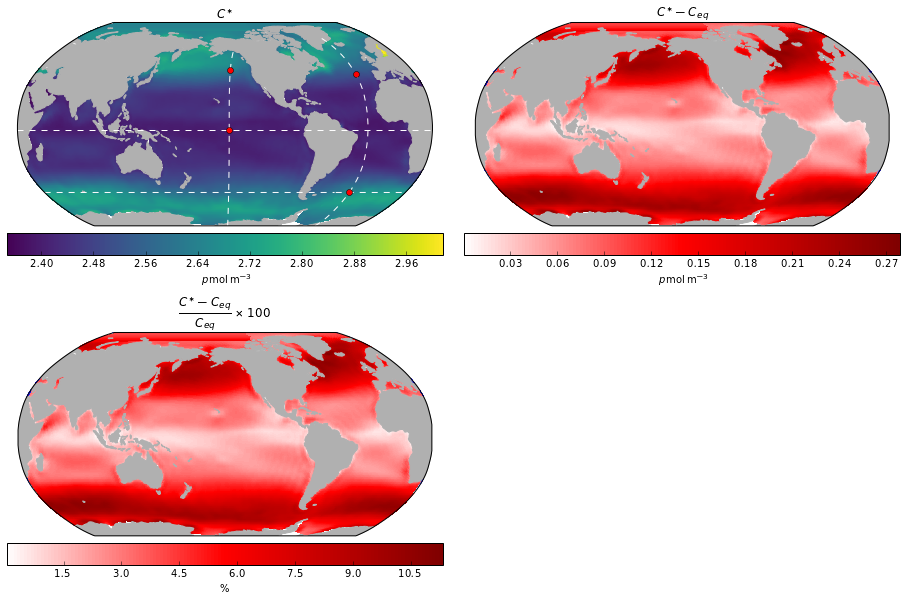

In [10]:
fig, axs = plt.subplots(nrows=2,ncols=2, subplot_kw={'projection':proj},figsize=(16,10))
fig.subplots_adjust(wspace=0.05,hspace=0.25)
fig.delaxes(axs[1,1])

ii, jj = 55, 12
iend, jj2 = 330, 225
ii2 = 180
pts = ((55,jj),(304,jj),(ii2,225),(300,jj2))

axs[0,0].add_feature(cfeature.LAND,facecolor='#b0b0b0')
pm = axs[0,0].pcolormesh(tlonc,tlatc,Cstar*1.e+12,transform=ccrs.PlateCarree()) # mol/m^3 -> pmol/m^3
l1 = axs[0,0].plot(tlon[:,jj],tlat[:,jj],'w--',transform=ccrs.Geodetic())
l2 = axs[0,0].plot(tlon[ii,:],tlat[ii,:],'w--',transform=ccrs.Geodetic())
l3 = axs[0,0].plot(tlon[:iend,jj2],tlat[:iend,jj2],'w--',transform=ccrs.Geodetic())
l4 = axs[0,0].plot(tlon[ii2,:],tlat[ii2,:],'w--',transform=ccrs.Geodetic())
for p in pts:
    i, j = p
    l = axs[0,0].plot(tlon[i,j],tlat[i,j],'ro',transform=ccrs.Geodetic())
cb = fig.colorbar(pm,ax=axs[0,0],orientation='horizontal',pad=0.03)
cb.set_label(r'$p$mol m$^{-3}$')
axs[0,0].set(title=r'$C^*$')
vmin, vmax = pm.get_clim()

axs[0,1].add_feature(cfeature.LAND,facecolor='#b0b0b0')
data = (Cstar - he3_sat)*1.e+12                      # mol/m^3 -> pmol/m^3
pm = axs[0,1].pcolormesh(tlonc,tlatc,data,transform=ccrs.PlateCarree(),cmap=plt.cm.seismic)
center_cmap(pm)
cb = fig.colorbar(pm,ax=axs[0,1],orientation='horizontal',pad=0.03)
cb.set_label(r'$p$mol m$^{-3}$')
axs[0,1].set(title=r'$C^* - C_{eq}$')

axs[1,0].add_feature(cfeature.LAND,facecolor='#b0b0b0')
data = (Cstar - he3_sat)/he3_sat * 100
pm = axs[1,0].pcolormesh(tlonc,tlatc,data,transform=ccrs.PlateCarree(),cmap=plt.cm.seismic)
center_cmap(pm)
cb = fig.colorbar(pm,ax=axs[1,0],orientation='horizontal',pad=0.03)
cb.set_label(r'\%')
axs[1,0].set(title=r'$\displaystyle \frac{C^* - C_{eq}}{C_{eq}}\times 100$')

#### Check results

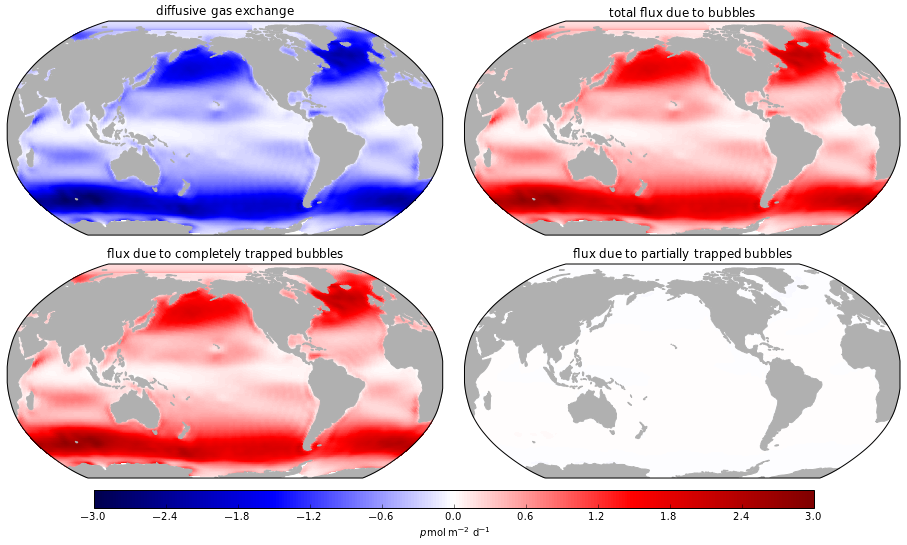

In [21]:
Fge = k * (he3_sat - Cstar)         # diffusive gas exchange
Pw = Cstar / (he4_sol * alpha_sol)  # 3He partial pressure in water
Fp = A * (Pb - Pw)                  # flux due to partially trapped bubbles
Fbubble = Fp + Fc                   # total bubble flux

fig, ax = plt.subplots(nrows=2,ncols=2, subplot_kw={'projection':proj},figsize=(16,8.5))
fig.subplots_adjust(wspace=0.05,hspace=0.05)

ax[0,0].add_feature(cfeature.LAND,facecolor='#b0b0b0')
flux = Fge * 1.e+12 * spd                                      # mol/m^2/s -> pmol/m^2/d
pm = ax[0,0].pcolormesh(tlonc,tlatc,flux,transform=ccrs.PlateCarree(),cmap=plt.cm.seismic,vmin=-3,vmax=3)
ax[0,0].set(title=r'diffusive gas exchange')

ax[0,1].add_feature(cfeature.LAND,facecolor='#b0b0b0')
flux = Fbubble * 1.e+12 * spd                                  # mol/m^2/s -> pmol/m^2/d
pm = ax[0,1].pcolormesh(tlonc,tlatc,flux,transform=ccrs.PlateCarree(),cmap=plt.cm.seismic,vmin=-3,vmax=3)
ax[0,1].set(title=r'total flux due to bubbles')

ax[1,0].add_feature(cfeature.LAND,facecolor='#b0b0b0')
flux = Fc * 1.e+12 * spd                                       # mol/m^2/s -> pmol/m^2/d
pm = ax[1,0].pcolormesh(tlonc,tlatc,flux,transform=ccrs.PlateCarree(),cmap=plt.cm.seismic,vmin=-3,vmax=3)
ax[1,0].set(title=r'flux due to completely trapped bubbles')

ax[1,1].add_feature(cfeature.LAND,facecolor='#b0b0b0')
flux = Fp * 1.e+12 * spd                                      # mol/m^2/s -> pmol/m^2/d
pm = ax[1,1].pcolormesh(tlonc,tlatc,flux,transform=ccrs.PlateCarree(),cmap=plt.cm.seismic,vmin=-3,vmax=3)
#cs = axs[1,1].contour(loncp,tlat,flux,[0],colors='k',transform=ccrs.PlateCarree())
ax[1,1].set(title=r'flux due to partially trapped bubbles')

cax = fig.add_axes((0.2,0.09,0.625,0.03))
cb = fig.colorbar(pm,cax=cax,orientation='horizontal')
cb.set_label(r'$p$mol m$^{-2}$ d$^{-1}$')

##### Total gas flux = 0

In [12]:
Ftot = Fge + Fc + Fp
np.allclose(Ftot,0)

True

## Relationship between $C^*$ and temperature

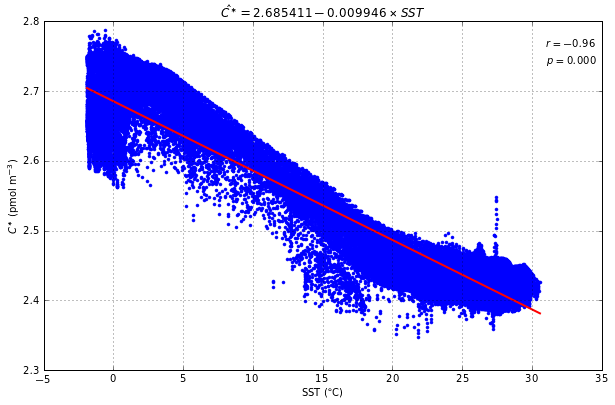

In [13]:
sstm = ma.masked_where(rmask<0,temp[0,...]) # marginal seas have oulier points so mask them
Cstarm = ma.masked_where(rmask<0,Cstar)

mask = sstm.mask | Cstarm.mask  # compute common mask
sstm = ma.array(sstm,mask=mask) # apply new mask
Cstarm = ma.array(Cstarm,mask=mask)
x, y = sstm.ravel().compressed(), Cstarm.ravel().compressed()
slope, icpt, r, p, err = linregress(x,y) # linear regression
xnew = np.linspace(x.min(),x.max())
ynew = icpt + slope * xnew

fig, ax = plt.subplots(figsize=(10,6.25))
l1, = ax.plot(x,y*1.e+12,'b.')
l2, = ax.plot(xnew,ynew*1.e+12,'r-',lw=2)
tx  = ax.text(0.9,0.95,'$r = %.2f$'%r,ha='left',va='top',transform=ax.transAxes)
tx  = ax.text(0.9,0.9,'$p = %.3f$'%p,ha='left',va='top',transform=ax.transAxes)
lb = ax.set(xlabel='SST ($^{\circ}$C)',ylabel=r'$C^*$ (pmol m$^{-3}$)',
            title=r'$\hat{C^*} = %.6f %.6f \times SST$'%(icpt*1.e+12,slope*1.e+12))
ax.grid('on')

### Set $C^*$ at ocean interior following regression

In [14]:
Cstar3D = icpt + slope * temp
Cstar3D[0,...] = Cstar

### Vertical sections of $C^*$

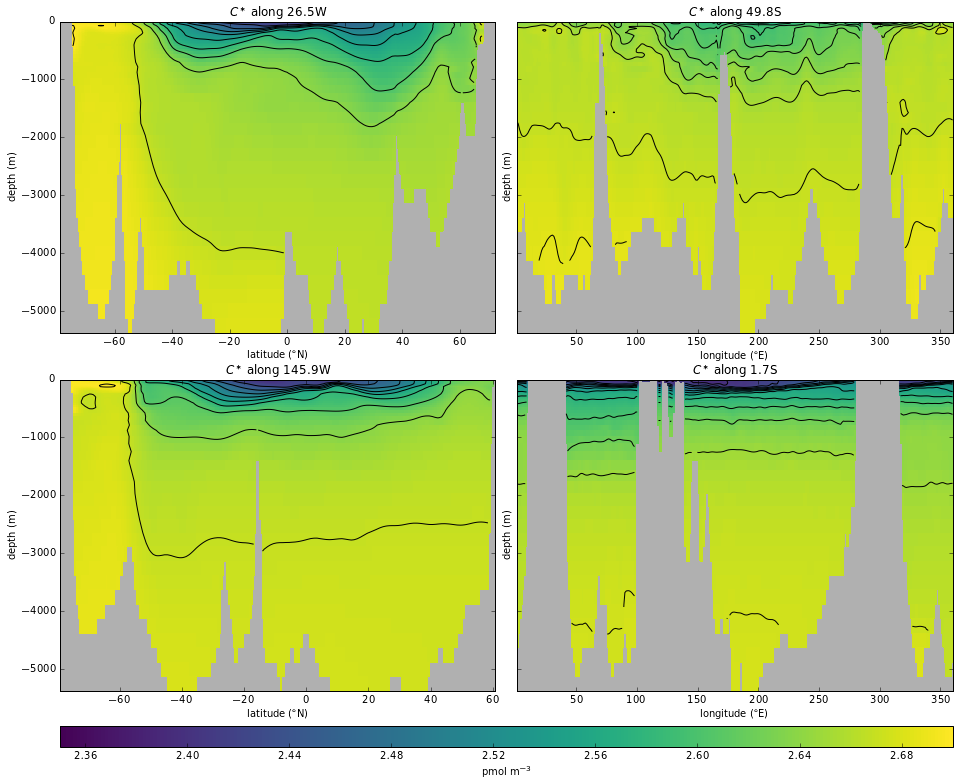

In [15]:
fig, axs = plt.subplots(nrows=2,ncols=2,sharey=True,figsize=(16,12))
fig.subplots_adjust(wspace=0.05,hspace=0.15)

data = Cstar3D * 1.e+12 # mo/m^3 -> pmol/m^3
vmin, vmax = 2.35, 2.70
#clev = ticker.MaxNLocator(nbins=20).tick_values(vmin,vmax)
clev = 12

pm = axs[0,0].pcolormesh(tlat[:,jj],-zt,data[:,:,jj],vmin=vmin,vmax=vmax)
cs = axs[0,0].contour(tlat[:,jj],-zt,data[:,:,jj],clev,colors='k')
title = r'$C^*$ along %.1fW'%(360-tlon[:,jj].mean())
axs[0,0].set(title=title,xlabel='latitude ($^{\circ}$N)',ylabel='depth (m)')
axs[0,0].set_axis_bgcolor('#b0b0b0')

jind = np.diff(tlon[ii,:]).argmin() + 1
lon = np.concatenate((tlon[ii,jind:],tlon[ii,:jind]))
data2 = ma.concatenate((Cstar3D[:,ii,jind:],Cstar3D[:,ii,:jind]),axis=-1) * 1.e+12 # mo/m^3 -> pmol/m^3
pm = axs[0,1].pcolormesh(lon,-zt,data2,vmin=vmin,vmax=vmax)
cs = axs[0,1].contour(lon,-zt,data2,clev,colors='k')
title = r'$C^*$ along %.1fS'%(-tlat[ii,:].mean())
axs[0,1].set(title=title,xlabel='longitude ($^{\circ}$E)',ylabel='depth (m)')
axs[0,1].set_axis_bgcolor('#b0b0b0')

pm = axs[1,0].pcolormesh(tlat[:iend,jj2],-zt,data[:,:iend,jj2],vmin=vmin,vmax=vmax)
cs = axs[1,0].contour(tlat[:iend,jj2],-zt,data[:,:iend,jj2],clev,colors='k')
title = r'$C^*$ along %.1fW'%(360-tlon[:iend,jj2].mean())
axs[1,0].set(title=title,xlabel='latitude ($^{\circ}$N)',ylabel='depth (m)')
axs[1,0].set_axis_bgcolor('#b0b0b0')

jind = np.diff(tlon[ii2,:]).argmin() + 1
lon = np.concatenate((tlon[ii2,jind:],tlon[ii2,:jind]))
data2 = ma.concatenate((Cstar3D[:,ii2,jind:],Cstar3D[:,ii2,:jind]),axis=-1) * 1.e+12 # mo/m^3 -> pmol/m^3
pm = axs[1,1].pcolormesh(lon,-zt,data2,vmin=vmin,vmax=vmax)
cs = axs[1,1].contour(lon,-zt,data2,clev,colors='k')
title = r'$C^*$ along %.1fS'%(-tlat[ii2,:].mean())
axs[1,1].set(title=title,xlabel='longitude ($^{\circ}$E)',ylabel='depth (m)')
axs[1,1].set_axis_bgcolor('#b0b0b0')

cax = fig.add_axes((0.125,0.06,0.775,0.025))
cb = fig.colorbar(pm,cax=cax,orientation='horizontal')#,ticks=clev)
cb.set_label(r'pmol m$^{-3}$')

### Vertical sections of $\displaystyle \frac{C^* - C_{eq}}{C_{eq}} \times 100$

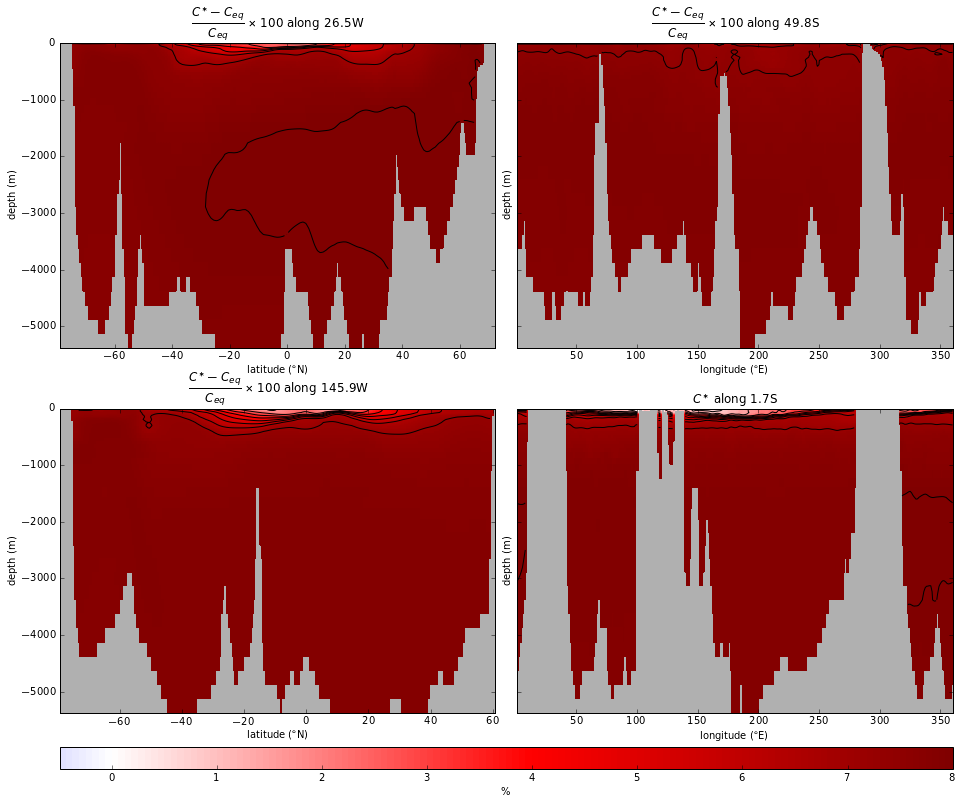

In [16]:
sol3D = comp_henry_he_sol_0(temp,salt)
alpha3D = alpha_sol_he(temp)
he4_sat_3D = sol3D * Xhe * Patm
he3_sat_3D = he4_sat_3D * Ir  * alpha3D

fig, axs = plt.subplots(nrows=2,ncols=2,sharey=True,figsize=(16,12))
fig.subplots_adjust(wspace=0.05,hspace=0.2)

data = (Cstar3D - he3_sat_3D)/he3_sat_3D * 100
vmin, vmax = -0.5, 8
#clev = ticker.MaxNLocator(nbins=15).tick_values(vmin,vmax)
clev = 12

pm = axs[0,0].pcolormesh(tlat[:,jj],-zt,data[:,:,jj],cmap=plt.cm.seismic,vmin=vmin,vmax=vmax)
cs = axs[0,0].contour(tlat[:,jj],-zt,data[:,:,jj],clev,colors='k',vmin=vmin,vmax=vmax)
center_cmap(pm)
title = r'$\displaystyle \frac{C^* - C_{eq}}{C_{eq}} \times 100$ along %.1fW'%(360-tlon[:,jj].mean())
axs[0,0].set(title=title,xlabel='latitude ($^{\circ}$N)',ylabel='depth (m)')
axs[0,0].set_axis_bgcolor('#b0b0b0')

jind = np.diff(tlon[ii,:]).argmin() + 1
lon = np.concatenate((tlon[ii,jind:],tlon[ii,:jind]))
data2 = ma.concatenate((data[:,ii,jind:],data[:,ii,:jind]),axis=-1)
pm = axs[0,1].pcolormesh(lon,-zt,data2,cmap=plt.cm.seismic,vmin=vmin,vmax=vmax)
cs = axs[0,1].contour(lon,-zt,data2,clev,colors='k',vmin=vmin,vmax=vmax)
center_cmap(pm)
title = r'$\displaystyle \frac{C^* - C_{eq}}{C_{eq}} \times 100$ along %.1fS'%(-tlat[ii,:].mean())
axs[0,1].set(title=title,xlabel='longitude ($^{\circ}$E)',ylabel='depth (m)')
axs[0,1].set_axis_bgcolor('#b0b0b0')

pm = axs[1,0].pcolormesh(tlat[:iend,jj2],-zt,data[:,:iend,jj2],cmap=plt.cm.seismic,vmin=vmin,vmax=vmax)
cs = axs[1,0].contour(tlat[:iend,jj2],-zt,data[:,:iend,jj2],clev,colors='k',vmin=vmin,vmax=vmax)
center_cmap(pm)
title = r'$\displaystyle \frac{C^* - C_{eq}}{C_{eq}} \times 100$ along %.1fW'%(360-tlon[:iend,jj2].mean())
axs[1,0].set(title=title,xlabel='latitude ($^{\circ}$N)',ylabel='depth (m)')
axs[1,0].set_axis_bgcolor('#b0b0b0')

jind = np.diff(tlon[ii2,:]).argmin() + 1
lon = np.concatenate((tlon[ii2,jind:],tlon[ii2,:jind]))
data2 = ma.concatenate((data[:,ii2,jind:],data[:,ii2,:jind]),axis=-1)
pm = axs[1,1].pcolormesh(lon,-zt,data2,cmap=plt.cm.seismic,vmin=vmin,vmax=vmax)
cs = axs[1,1].contour(lon,-zt,data2,clev,colors='k')
center_cmap(pm)
title = r'$C^*$ along %.1fS'%(-tlat[ii2,:].mean())
axs[1,1].set(title=title,xlabel='longitude ($^{\circ}$E)',ylabel='depth (m)')
axs[1,1].set_axis_bgcolor('#b0b0b0')

cax = fig.add_axes((0.125,0.06,0.775,0.025))
cb = fig.colorbar(pm,cax=cax,orientation='horizontal')#,ticks=clev)
cb.set_label('\%')

### Vertical profiles of $C^*$ & $C_{eq}$

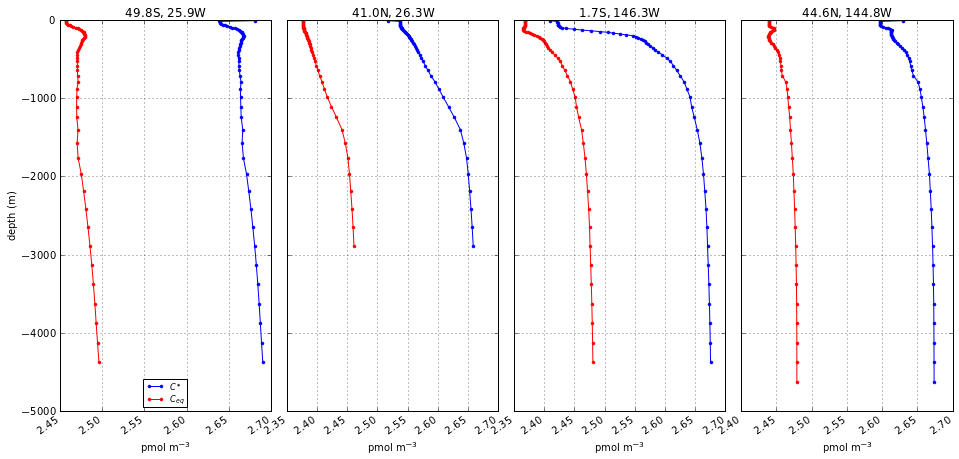

In [17]:
fig, axs = plt.subplots(nrows=1,ncols=4,sharey=True,figsize=(16,7))
fig.subplots_adjust(wspace=0.075)
axs = axs.ravel()
for n in range(len(pts)):
    i, j = pts[n]
    l = axs[n].plot(Cstar3D[:,i,j] * 1.e+12,-zt,'.-',label=r'$C^*$')
    l = axs[n].plot(he3_sat_3D[:,i,j] * 1.e+12,-zt,'.-',label=r'$C_{eq}$')
    plt.setp(axs[n].get_xticklabels(),rotation=35,horizontalalignment='right')
    axs[n].grid('on')
    latlab = '%.1fN'%(tlat[i,j]) if tlat[i,j]>0 else '%.1fS'%(-tlat[i,j])
    title = '%s, %.1fW'%(latlab,360-tlon[i,j])
    axs[n].set(title=title,xlabel=r'pmol m$^{-3}$')

axs[0].set(ylabel='depth (m)')
axs[0].legend(loc='lower center')

## Set initial tritium to zero

In [18]:
tr0 = ma.array(np.zeros(he3_sat_3D.shape),mask=he3_sat_3D.mask)

## Write initial fields to netCDF file

In [19]:
he3_sat_pmol = he3_sat_3D * 1.e+12 # mol/m^3 -> pmol/m^3
he4_sat_umol = he4_sat_3D * 1.e+6  # mol/m^3 -> umol/m^3
Cstar_pmol   = Cstar3D    * 1.e+12 # mol/m^3 -> pmol/m^3

fpin = netCDF4.Dataset(os.path.join(datadir,'ecosys_jan_IC_gx1v6_corrO2_Feb2013.nc'),'r')

outfile = os.path.join(datadir,'tritium_3He_init_balanced.nc')
if os.path.isfile(outfile):
    os.remove(outfile)

fpout = netCDF4.Dataset(outfile,'w',format='NETCDF3_CLASSIC')
fpout.contents = """Initial tritium, 3He and 4He fields for CESM. 
Tritium is set to zero and Helium 3 is set to super saturation
so that the diffusive gas exchange balances the gas flux due 
to bubbles."""
fpout.history = 'Created by Ivan Lima <ivan@whoi.edu> on %s'%datetime.datetime.now().ctime()

for dim in ['z_t','nlat','nlon','Y','X']:
    fpout.createDimension(dim,len(fpin.dimensions[dim]))

for vname in ['z_t','TLAT','TLONG','KMT']:
    ncvar = fpout.createVariable(vname,fpin.variables[vname][:].dtype.char,fpin.variables[vname].dimensions)
    for attr in fpin.variables[vname].ncattrs():
        setattr(ncvar,attr,getattr(fpin.variables[vname],attr))
    ncvar[:] = fpin.variables[vname][:]
    
ncvar = fpout.createVariable('TRITIUM','f',('z_t','nlat','nlon'),fill_value=tr0.fill_value)
ncvar.missing_value = tr0.fill_value
ncvar.long_name = 'tritium'
ncvar.units = 'pmol/m^3'
ncvar.coordinates = 'TLONG TLAT z_t time'
ncvar[:] = tr0.astype(np.float32)

ncvar = fpout.createVariable('HELIUM3','f',('z_t','nlat','nlon'),fill_value=he3_sat.fill_value)
ncvar.missing_value = he3_sat.fill_value
ncvar.long_name = 'helium 3'
ncvar.units = 'pmol/m^3'
ncvar.coordinates = 'TLONG TLAT z_t time'
ncvar[:] = Cstar_pmol.astype(np.float32)

# ncvar = fpout.createVariable('HELIUM4','f',('z_t','nlat','nlon'),fill_value=he4_sat.fill_value)
# ncvar.missing_value = he4_sat.fill_value
# ncvar.long_name = 'helium 4'
# ncvar.units = 'umol/m^3'
# ncvar.coordinates = 'TLONG TLAT z_t time'
# ncvar[:] = he4_sat_umol.astype(np.float32)

fpin.close()
fpout.close()